In [147]:
#Made in Python3 environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('CleanedAirline.csv')
print(df.head())

  First Name Last Name  Gender  Age Age Group Nationality  \
0     Edithe    Leggis  Female   62    Senior       Japan   
1     Elwood      Catt    Male   62    Senior   Nicaragua   
2      Darby   Felgate    Male   67    Senior      Russia   
3   Dominica      Pyle  Female   71    Senior       China   
4        Bay   Pencost    Male   21     Adult       China   

                Airport Name   Country Name Airport Continent     Continents  \
0           Coldfoot Airport  United States               NAM  North America   
1          Kugluktuk Airport         Canada               NAM  North America   
2      Grenoble-Isre Airport         France                EU         Europe   
3  Ottawa / Gatineau Airport         Canada               NAM  North America   
4            Gillespie Field  United States               NAM  North America   

  Departure Date  Weekend  Season Arrival Airport Flight Status  
0     2022-06-28        0  Summer             CXF       On Time  
1     2022-12-26    

In [291]:
df.isnull().sum()

First Name           0
Last Name            0
Gender               0
Age                  0
Age Group            0
Nationality          0
Airport Name         0
Country Name         0
Airport Continent    0
Continents           0
Departure Date       0
Weekend              0
Season               0
Arrival Airport      0
Flight Status        0
Month                0
Gender-Age Group     0
Departure Month      0
Departure Day        0
Departure Weekday    0
IsChinese            0
IsNorthAmerica       0
IsUnitedStates       0
YearMonth            0
Day_of_Week          0
dtype: int64

# __Data Exploration__ : 

## __1. ) A general look at the data__: 

## We are going to explore over:
1. Age
2. Age Group
3. Gender


In [7]:
# General Age Distribution
df['Age Group'].value_counts()

Age Group
Adult     47300
Senior    32772
Minor     18547
Name: count, dtype: int64

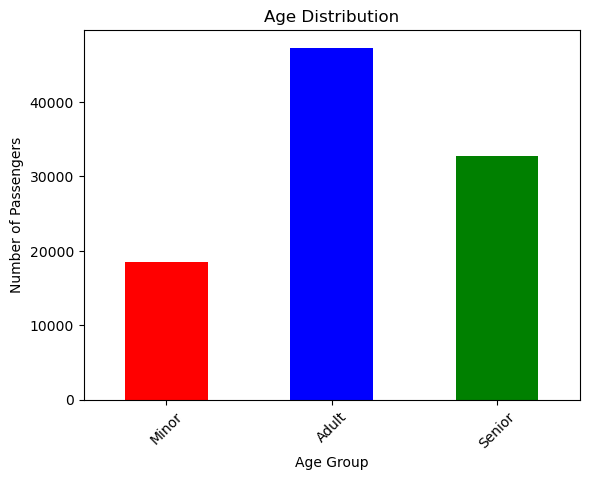

In [9]:
#Passenger Demographic (Bar Chart) 
# Count the occurrences of each Age Group
age_group_counts = df['Age Group'].value_counts()

custom_order = ['Minor', 'Adult', 'Senior']
age_group_counts = age_group_counts.reindex(custom_order)

colors = ['red', 'blue', 'green']

age_group_counts.plot(kind='bar', title='Age Distribution', color=colors)
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)


plt.show()

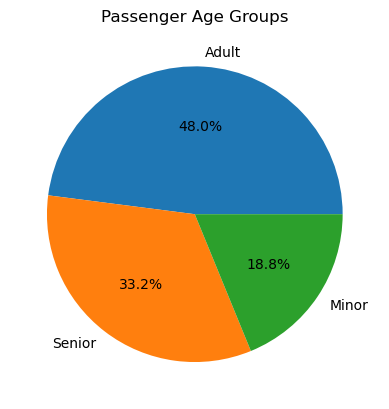

In [11]:
# Age Demographic (Pie Chart)
df['Age Group'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Passenger Age Groups')
plt.ylabel('')
plt.show()

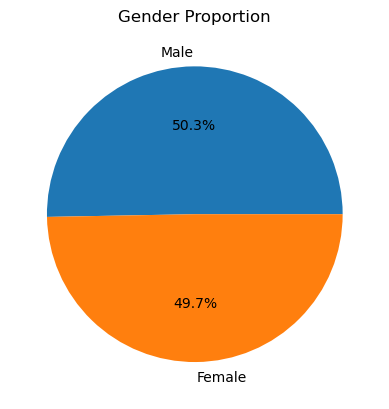

In [13]:
#Gender Proportion
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Gender Proportion')
plt.ylabel('')  
plt.show()

In [15]:
# More Detailed Idea of Age Group and Gender
# Group by 'Age Group' and 'Gender' and count rows
passenger_segments = df.groupby(['Age Group', 'Gender']).size().reset_index(name='PassengerCount')

# Sort by 'Age Group' for consistency
passenger_segments = passenger_segments.sort_values(by=['Age Group', 'Gender'])
print(passenger_segments)

  Age Group  Gender  PassengerCount
0     Adult  Female           23563
1     Adult    Male           23737
2     Minor  Female            9179
3     Minor    Male            9368
4    Senior  Female           16279
5    Senior    Male           16493


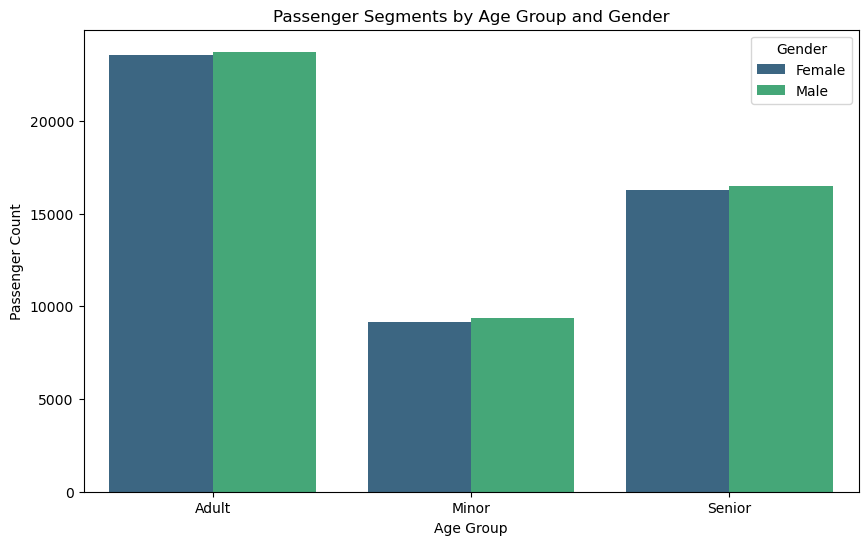

In [17]:
# Bar plot for passenger segments
plt.figure(figsize=(10, 6))
sns.barplot(
    data=passenger_segments, 
    x='Age Group', 
    y='PassengerCount', 
    hue='Gender', 
    palette='viridis'
)
plt.title('Passenger Segments by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Passenger Count')
plt.legend(title='Gender')
plt.show()

In [123]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['YearMonth'] = df['Departure Date'].dt.to_period('M')

# Group data by 'YearMonth' and 'Age Group' to get monthly passenger counts
time_series_data = df.groupby(['YearMonth', 'Age Group'])['Gender'].count().reset_index()
time_series_data.rename(columns={'Gender': 'PassengerCount'}, inplace=True)

# Pivot the table to create separate columns for each Age Group
pivoted_data = time_series_data.pivot(index='YearMonth', columns='Age Group', values='PassengerCount').fillna(0)

# Ensure the index is sorted by date
pivoted_data = pivoted_data.sort_index()
print(pivoted_data)

Age Group  Adult  Minor  Senior
YearMonth                      
2022-01     4051   1588    2777
2022-02     3667   1457    2529
2022-03     4101   1599    2731
2022-04     3780   1456    2723
2022-05     4106   1555    2835
2022-06     3928   1564    2636
2022-07     4122   1485    2844
2022-08     4116   1614    2814
2022-09     3831   1511    2807
2022-10     3974   1653    2788
2022-11     3850   1549    2654
2022-12     3774   1516    2634


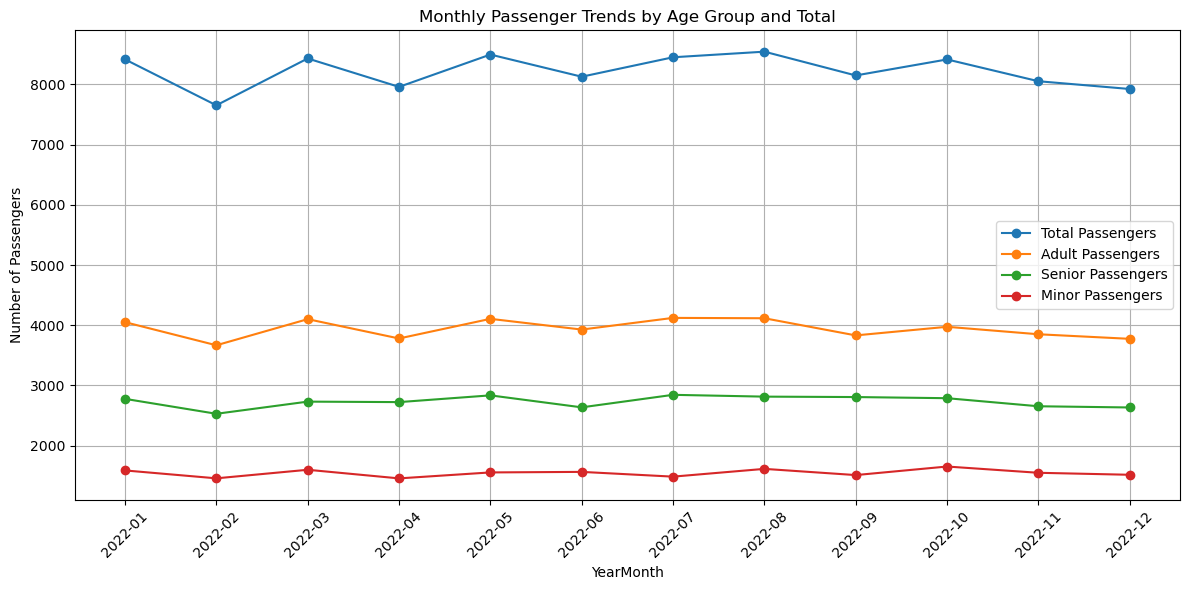

In [125]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['YearMonth'] = df['Departure Date'].dt.to_period('M')

# Group data by 'YearMonth' and 'Age Group' to get monthly passenger counts
time_series_data = df.groupby(['YearMonth', 'Age Group'])['Gender'].count().reset_index()
time_series_data.rename(columns={'Gender': 'PassengerCount'}, inplace=True)

# Pivot the table to create separate columns for each Age Group
pivoted_data = time_series_data.pivot(index='YearMonth', columns='Age Group', values='PassengerCount').fillna(0)

# Add a total column
pivoted_data['Total'] = pivoted_data.sum(axis=1)

# Group by Departure Date to calculate daily flight counts
daily_flights = df.groupby('Departure Date').size().reset_index(name='DailyFlights')

# Convert 'Departure Date' to datetime
daily_flights['Departure Date'] = pd.to_datetime(daily_flights['Departure Date'])

# Calculate the cumulative sum of flights
daily_flights['CumulativeFlights'] = daily_flights['DailyFlights'].cumsum()

# Combine cumulative flights into the monthly data
pivoted_data = pivoted_data.reset_index()
pivoted_data['YearMonth'] = pivoted_data['YearMonth'].astype(str)
daily_flights['YearMonth'] = daily_flights['Departure Date'].dt.to_period('M').astype(str)
monthly_flights = daily_flights.groupby('YearMonth')['CumulativeFlights'].max().reset_index()
combined_data = pd.merge(pivoted_data, monthly_flights, on='YearMonth', how='inner')

plt.figure(figsize=(12, 6))
plt.plot(combined_data['YearMonth'], combined_data['Total'], label='Total Passengers', marker='o')
plt.plot(combined_data['YearMonth'], combined_data['Adult'], label='Adult Passengers', marker='o')
plt.plot(combined_data['YearMonth'], combined_data['Senior'], label='Senior Passengers', marker='o')
plt.plot(combined_data['YearMonth'], combined_data['Minor'], label='Minor Passengers', marker='o')
plt.xticks(rotation=45)
plt.xlabel('YearMonth')
plt.ylabel('Number of Passengers')
plt.title('Monthly Passenger Trends by Age Group and Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Age
29    1170
27    1164
39    1155
46    1151
6     1148
58    1147
67    1145
48    1137
72    1136
24    1136
Name: count, dtype: int64


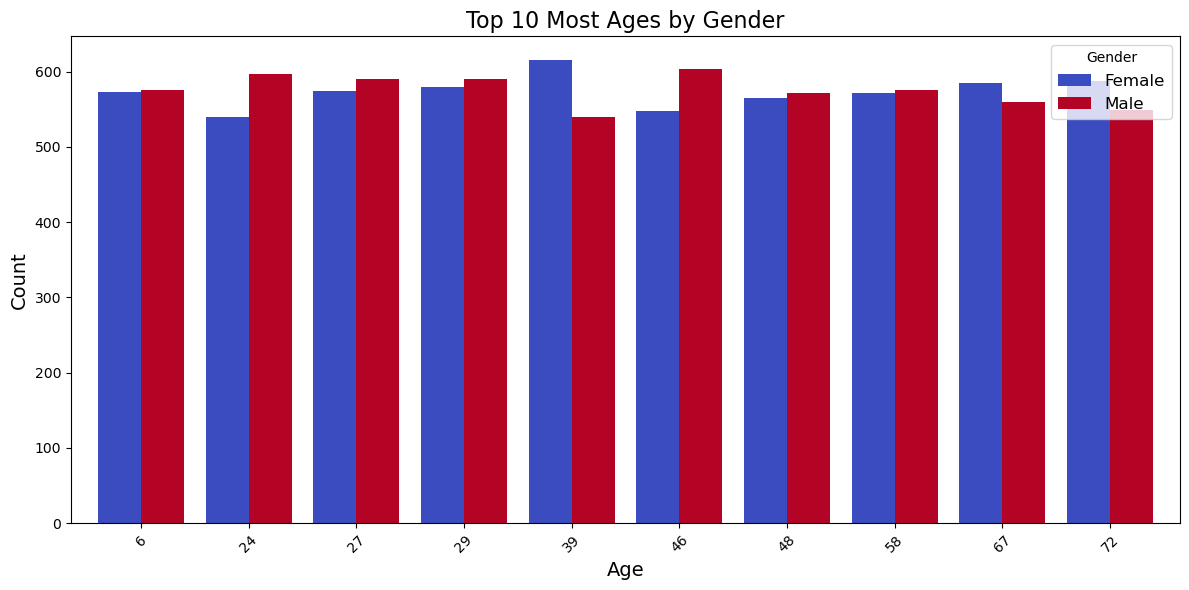

In [201]:
# Top 10 most common ages
top_10 = df['Age'].value_counts().head(10)
print(top_10)

# Filter data to include only top 10 values
# Find the top 10 most common values
top_10 = df['Age'].value_counts().head(10).index

# Filter data to include only top 10 values
filtered_df = df[df['Age'].isin(top_10)]

grouped = filtered_df.groupby(['Age', 'Gender']).size().unstack(fill_value=0)
grouped = grouped.astype(int)
grouped.plot(kind='bar', figsize=(12, 6), width=0.8, colormap='coolwarm')
plt.title('Top 10 Most Ages by Gender', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Gender', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### __Take away__:
1. Adults take up most of the Passenger Count while Minors take up the least
2. There are more Male Passengers than Female Passengers by 0.6%
3. Passengers with the age of 29 fly the most  

## __2.) Visualize Trends in Age Group and Monthy Passengers__

### Exploring Patterns through the Seasons

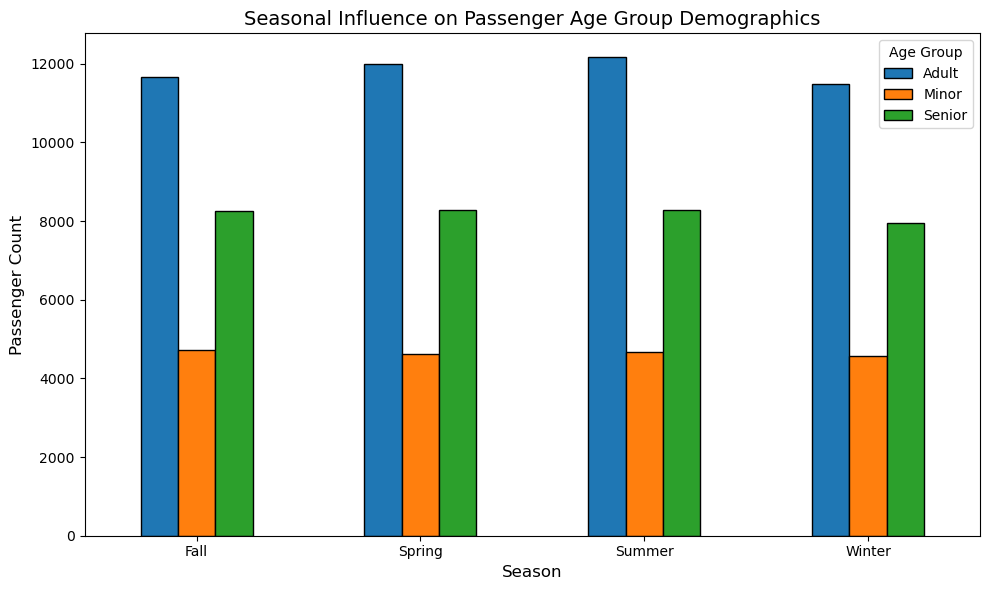

In [127]:
# Extract seasons based on the month from the 'Departure Date'
df['Season'] = df['Departure Date'].dt.month % 12 // 3 + 1
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(season_map)

# Group data by 'Season' and 'Age Group' to get total passenger counts per season
seasonal_data = df.groupby(['Season', 'Age Group'])['Gender'].count().reset_index()
seasonal_data.rename(columns={'Gender': 'PassengerCount'}, inplace=True)

# Pivot data to have Age Groups as columns
pivoted_seasonal_data = seasonal_data.pivot(index='Season', columns='Age Group', values='PassengerCount').fillna(0)

pivoted_seasonal_data.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title('Seasonal Influence on Passenger Age Group Demographics', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Age Group', fontsize=10)
plt.tight_layout()
plt.show()

In [85]:
# Group by Age Group and Nationality to calculate passenger count
passenger_counts = df.groupby(['Age Group', 'Nationality']).size().reset_index(name='PassengerCount')

# Sort by PassengerCount and take the top 10
top_10_passenger_counts = passenger_counts.sort_values('PassengerCount', ascending=False).head(10)

# Verify the data
print(top_10_passenger_counts)


    Age Group  Nationality  PassengerCount
42      Adult        China            8777
497    Senior        China            6051
92      Adult    Indonesia            5041
548    Senior    Indonesia            3523
273     Minor        China            3489
171     Adult       Russia            2728
162     Adult  Philippines            2573
323     Minor    Indonesia            1995
627    Senior       Russia            1872
28      Adult       Brazil            1817


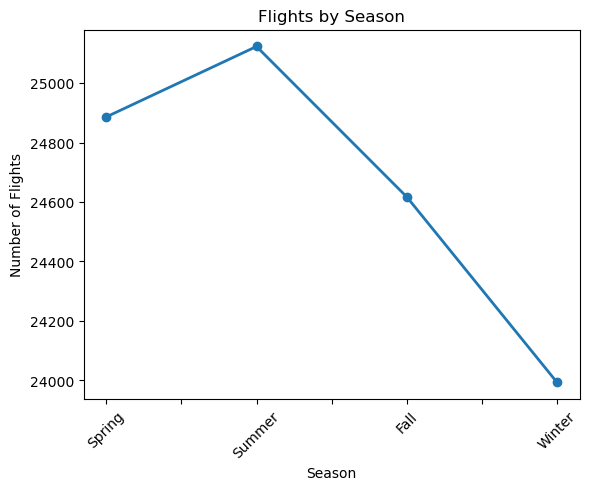

In [19]:
#Flight Season
seasons = df['Season'].value_counts()  

custom_order = ['Spring', 'Summer', 'Fall', 'Winter']
seasons = seasons.reindex(custom_order)

seasons.plot(kind='line', title='Flights by Season',  marker='o', linestyle='-', linewidth=2, color = '#1F77B4')

plt.xlabel('Season')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

/var/folders/43/98rnbf451v37yrd0y6srp2x80000gn/T/ipykernel_52170/4126395020.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_per_season = season_country_counts.groupby('Season').apply(
/var/folders/43/98rnbf451v37yrd0y6srp2x80000gn/T/ipykernel_52170/4126395020.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/43/98rnbf451v37yrd0y6srp2x80000gn/T/ipykernel_52170/4126395020.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `

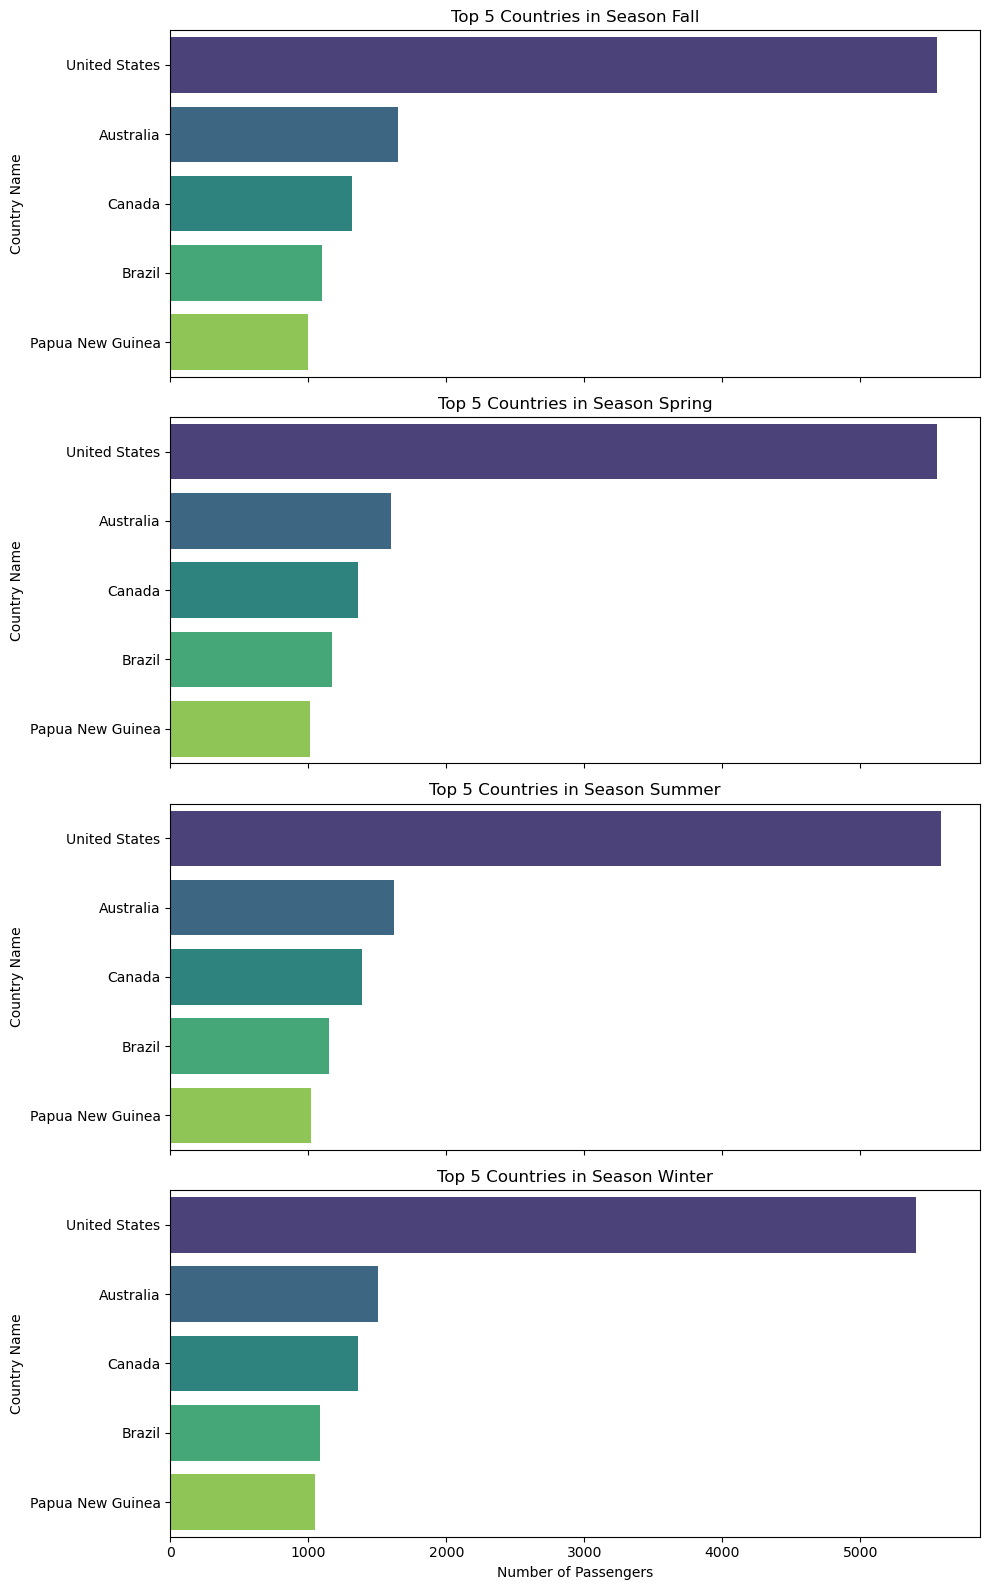

In [27]:
#Top 5 Visited Countries In Each Season

# Group data by season and country, then count occurrences
season_country_counts = df.groupby(['Season', 'Country Name'])['Country Name'].count().reset_index(name='Count')

# Filter top 5 countries for each season
top_5_per_season = season_country_counts.groupby('Season').apply(
    lambda x: x.nlargest(5, 'Count')
).reset_index(drop=True)

# Create a horizontal bar chart for each season
seasons = top_5_per_season['Season'].unique()
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

for i, season in enumerate(seasons):
    season_data = top_5_per_season[top_5_per_season['Season'] == season]
    sns.barplot(
        data=season_data,
        y='Country Name',
        x='Count',
        ax=axes[i],
        palette='viridis'
    )
    axes[i].set_title(f'Top 5 Countries in Season {season}')
    axes[i].set_xlabel('Number of Passengers')
    axes[i].set_ylabel('Country Name')

plt.tight_layout()
plt.show()

### __Take away__:
1. Summer has the highest amount of travlers while Winter has the lowest amount
2. The United States has the highest amount of vistors 

## __3.) Exploring General Impacts on Flight Status__

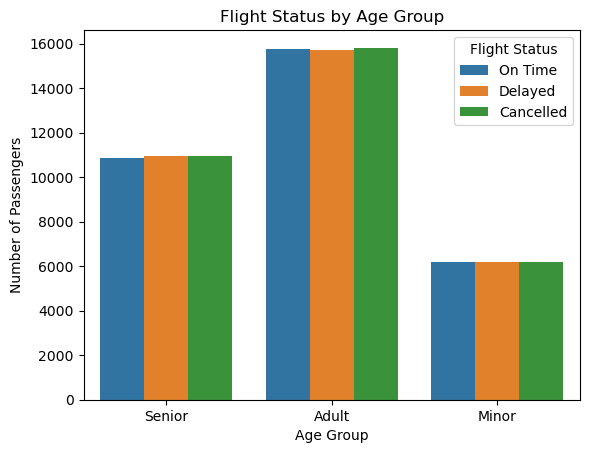

In [215]:
#Flight Status By Age Group
sns.countplot(data=df, x='Age Group', hue='Flight Status')
plt.title('Flight Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.show()


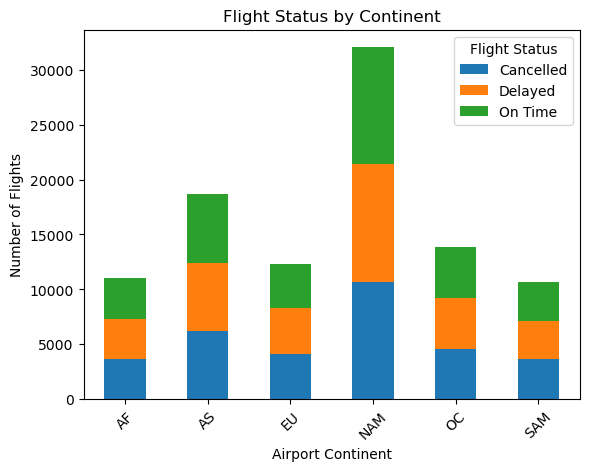

In [217]:
#Flight Season by Continent
pd.crosstab(df['Airport Continent'], df['Flight Status']).plot(kind='bar', stacked=True, title='Flight Status by Continent')

plt.xlabel('Airport Continent')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

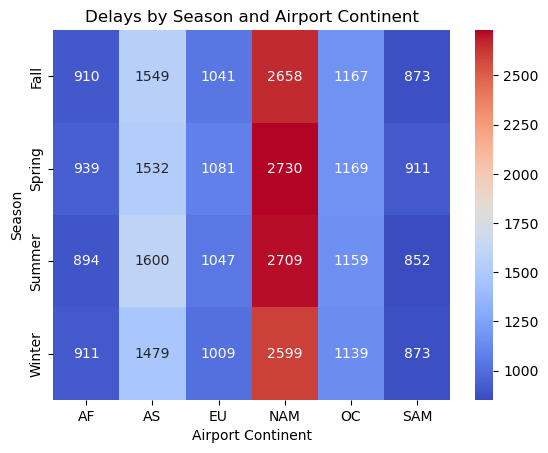

In [29]:
## What are the Impacts of Flight Delays on Overall Flight Operations

#Which Seasons Have the Most Delays?
delayed_flights = df[df['Flight Status'] == 'Delayed']

# Create a crosstab of delays by season and another variable (e.g., airport)
heatmap_data = pd.crosstab(delayed_flights['Season'], delayed_flights['Airport Continent'])

sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='d')
plt.title('Delays by Season and Airport Continent')
plt.xlabel('Airport Continent')
plt.ylabel('Season')

plt.show()


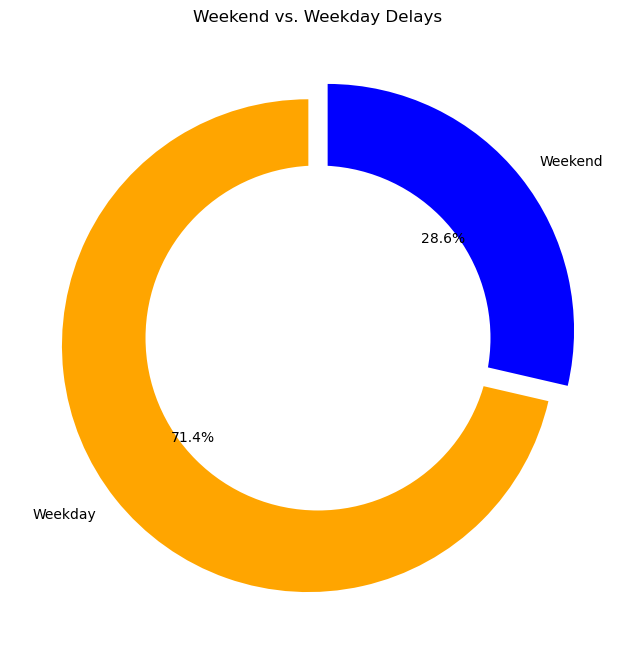

In [39]:
# Weekend vs. Weekday delays
# Plot a donut chart

labels = weekend_delays['Weekend']
sizes = weekend_delays['DelayedFlights']  # Number of delayed flights
colors = ['orange', 'blue']  
explode = (0.05, 0.05)  # Slightly separate the slices

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode
)

center_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(center_circle)
plt.title('Weekend vs. Weekday Delays')
plt.show()



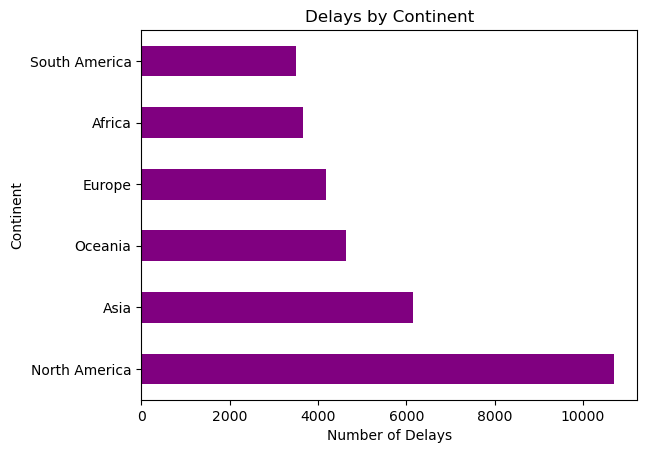

In [41]:
# Count delays by continent
delayed_flights = df[df['Flight Status'] == 'Delayed']
continent_delays = delayed_flights['Continents'].value_counts()

# Horizontal bar plot
continent_delays.plot(kind='barh', title='Delays by Continent', color='purple')
plt.xlabel('Number of Delays')
plt.ylabel('Continent')
plt.show()


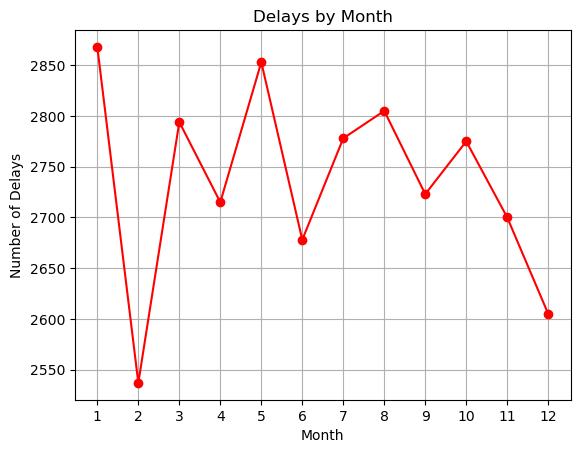

In [43]:
## Delay by Month
# Ensure the Departure Date column is in datetime format
df['Departure Date'] = pd.to_datetime(df['Departure Date'], format='%Y-%m-%d')

# Extract the month from Departure Date
df['Month'] = df['Departure Date'].dt.month

# Filter for delayed flights (if not already done)
delayed_flights = df[df['Flight Status'] == 'Delayed']

# Count the delays by month
month_delays = delayed_flights['Month'].value_counts().sort_index()

# Line plot for delays by month
month_delays.plot(kind='line', marker='o', title='Delays by Month', color='red')
plt.xlabel('Month')
plt.ylabel('Number of Delays')
plt.xticks(range(1, 13))  # Ensure x-axis shows all months from 1 to 12
plt.grid()
plt.show()


In [222]:
## Delayed Flights to their Total Flights per Month
# Ensure the Departure Date is in datetime format
df['Departure Date'] = pd.to_datetime(df['Departure Date'])

# Extract month from Departure Date
df['Month'] = df['Departure Date'].dt.month

# Total flights per month
total_flights_per_month = df['Month'].value_counts().sort_index()

# Delayed flights per month
delayed_flights_per_month = df[df['Flight Status'] == 'Delayed']['Month'].value_counts().sort_index()

# Combine the data into a single DataFrame for comparison
del_data = pd.DataFrame({
    'Total Flights': total_flights_per_month,
    'Delayed Flights': delayed_flights_per_month
})

print(del_data)

       Total Flights  Delayed Flights
Month                                
1               8416             2868
2               7653             2537
3               8431             2794
4               7959             2715
5               8496             2853
6               8128             2678
7               8451             2778
8               8544             2805
9               8149             2723
10              8415             2775
11              8053             2700
12              7924             2605


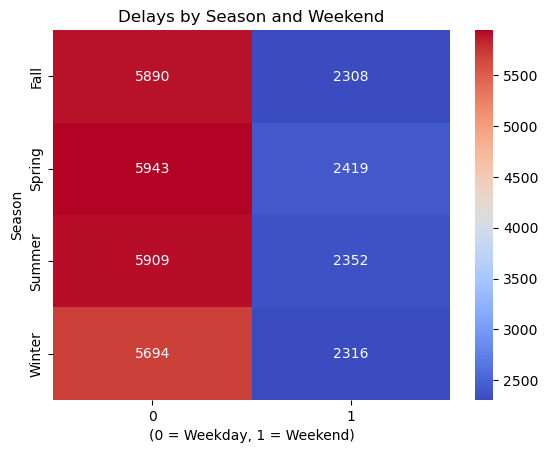

In [51]:
##Delayed Seasons and Weekend
# pivot table for season and weekend interaction
season_weekend_delays = delayed_flights.pivot_table(
    index='Season', 
    columns='Weekend', 
    values='Flight Status', 
    aggfunc='count', 
    fill_value=0
)

sns.heatmap(season_weekend_delays, annot=True, cmap='coolwarm', fmt='d')
plt.title('Delays by Season and Weekend')
plt.xlabel('(0 = Weekday, 1 = Weekend)')
plt.ylabel('Season')
plt.show()


In [119]:
# Group by Season and Country Name to calculate total and delayed flights
seasonal_delays = df.groupby(['Season', 'Country Name']).agg(
    TotalFlights=('Flight Status', 'count'),
    DelayedFlights=('Flight Status', lambda x: (x == 'Delayed').sum())
).reset_index()

# Calculate the delay percentage
seasonal_delays['DelayPercentage'] = (seasonal_delays['DelayedFlights'] / seasonal_delays['TotalFlights']) * 100

# Extract the top 10 delays
top_10_delays = seasonal_delays.sort_values(by='DelayPercentage', ascending=False).head(10)

# Print the top 10 delays
print(top_10_delays)

print(seasonal_delays.head())

     Season               Country Name  TotalFlights  DelayedFlights  \
637  Summer            Saint Barthlemy             1               1   
652  Summer  Sint Maarten (Dutch part)             3               3   
856  Winter                      Palau             1               1   
391  Spring                      Palau             1               1   
886  Winter  Sint Maarten (Dutch part)             1               1   
698  Winter                    Albania             2               2   
701  Winter                    Andorra             1               1   
784  Winter                   Guernsey             3               3   
409  Spring                Saint Lucia             4               4   
741  Winter    Cocos (Keeling) Islands             1               1   

     DelayPercentage  
637            100.0  
652            100.0  
856            100.0  
391            100.0  
886            100.0  
698            100.0  
701            100.0  
784            100.0  


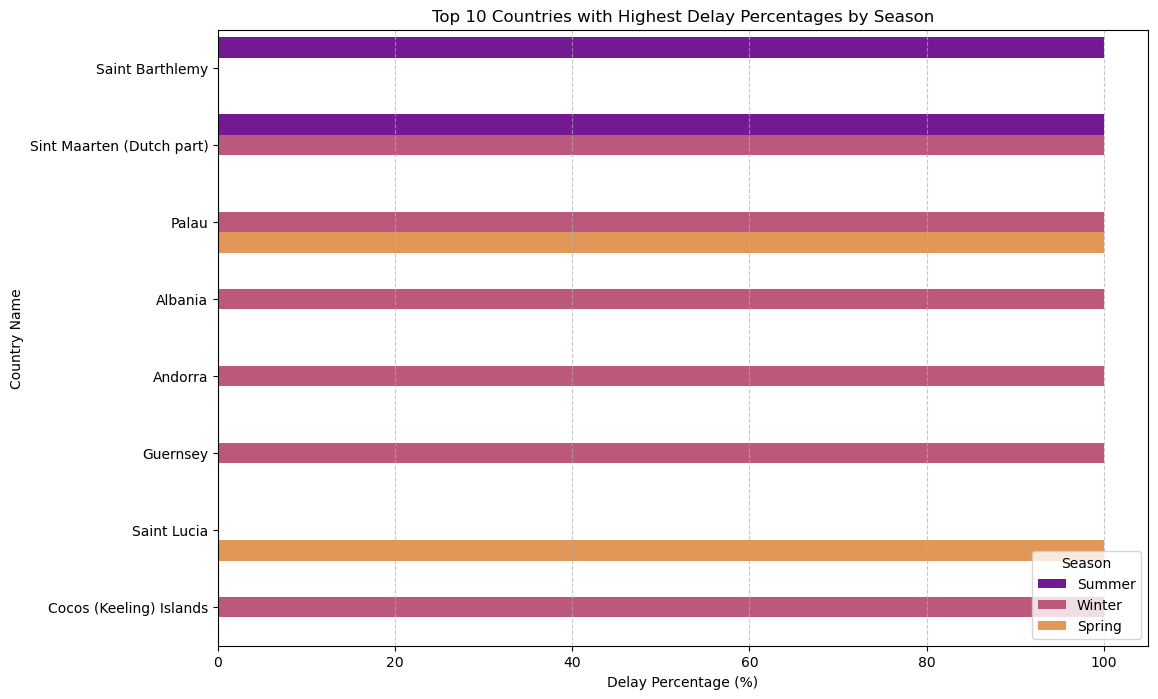

In [121]:
# Sort by DelayPercentage and filter the top 10 countries
top_10_delays = seasonal_delays.sort_values(by='DelayPercentage', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_delays,
    x='DelayPercentage',
    y='Country Name',
    hue='Season',
    palette='plasma'
)
plt.title('Top 10 Countries with Highest Delay Percentages by Season')
plt.xlabel('Delay Percentage (%)')
plt.ylabel('Country Name')
plt.legend(title='Season', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### __Take away__:
    1. Impact of Age Group on Flight Status: 
    Adults have the highest number of flights across all statuses, followed by seniors, with minors having the least
    
    2. Flight Status by Continent:
    North America (NAM) has the highest number of flights overall, including delays and cancellations, followed by Asia (AS)
       
    3. Seasonal Delays by Continent:
    Seasonal trends show delays are highest in North America regardless of the season, particularly in Fall and Spring. 

    4. Weekend vs. Weekday Delays:
    Most delays occur on weekdays (71.4%) compared to weekends (28.6%). This indicates higher traffic and operational challenges during weekdays.
   
    5. Delays by Continent: 
    North America leads in flight delays, significantly outpacing other continents, emphasizing its high volume of air traffic and potential for congestion.

    6. Delays by Month:
       There are notable fluctuations in delays by month, with peaks in January and July, likely due to holiday seasons and high travel demand.

    7. Seasonal Delays and Weekend Impact:
       Across all seasons, delays are higher on weekdays than weekends, with Fall seeing the most delays on both weekdays and weekends.


## __4.) Exploring Factors on Flight Status Using Classification__

              precision    recall  f1-score   support

   Cancelled       0.33      0.73      0.45      6446
     Delayed       0.34      0.12      0.18      6655
     On Time       0.33      0.15      0.20      6623

    accuracy                           0.33     19724
   macro avg       0.33      0.33      0.28     19724
weighted avg       0.33      0.33      0.27     19724



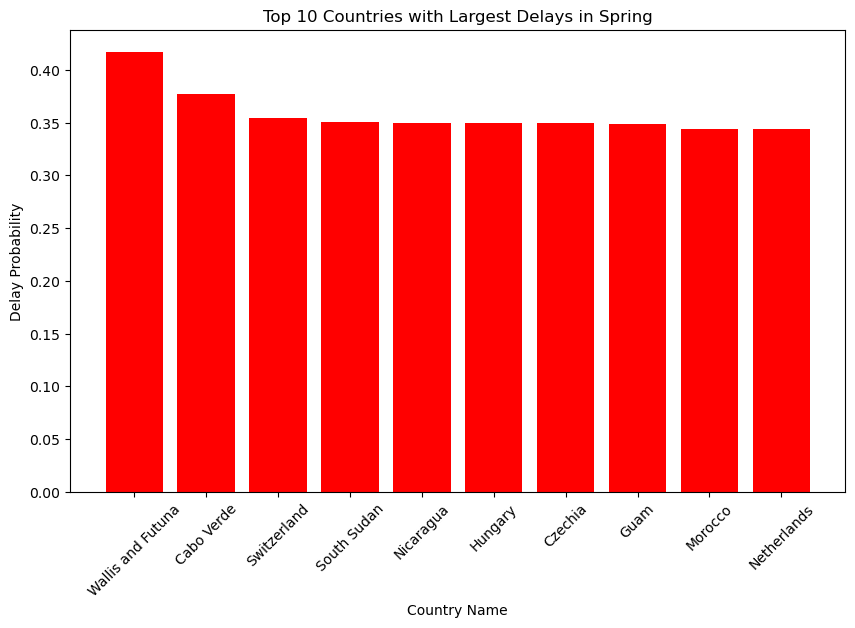

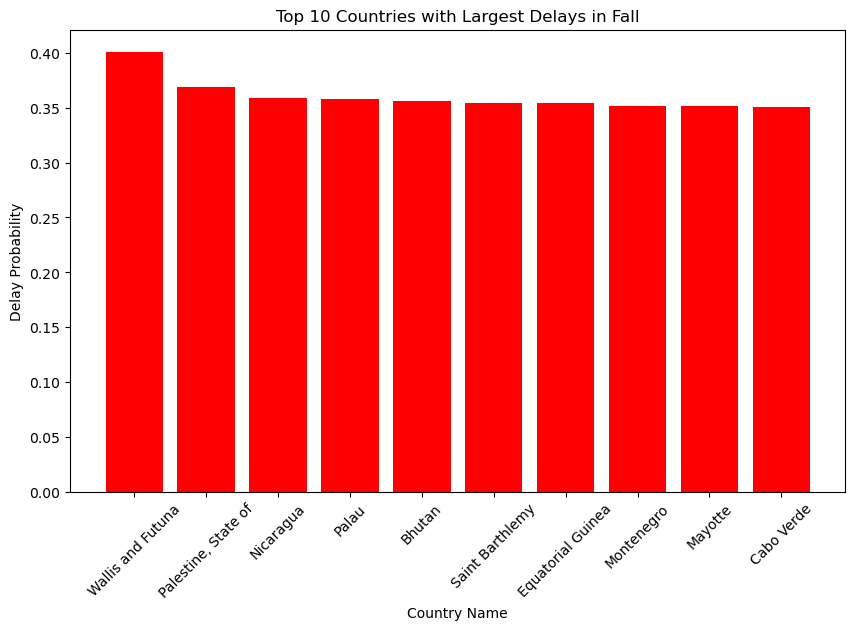

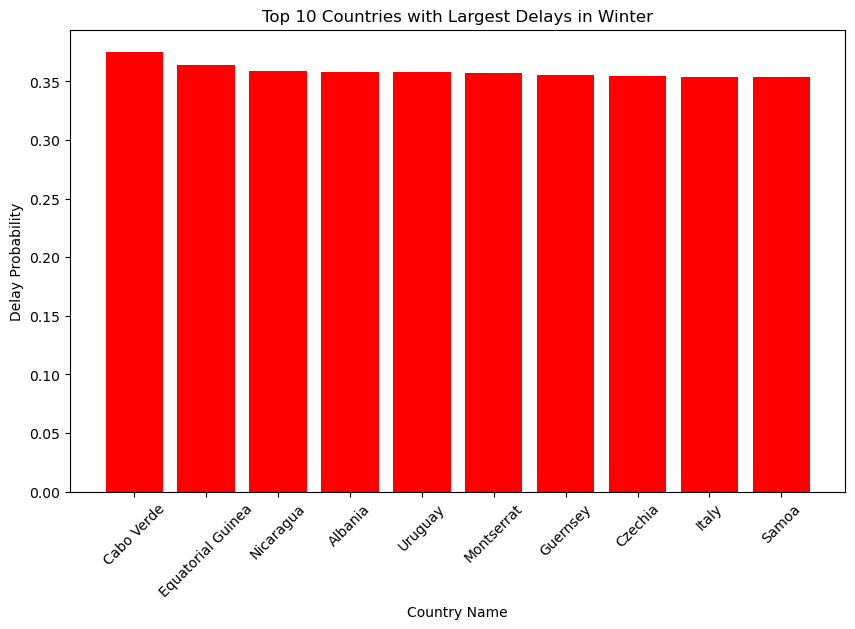

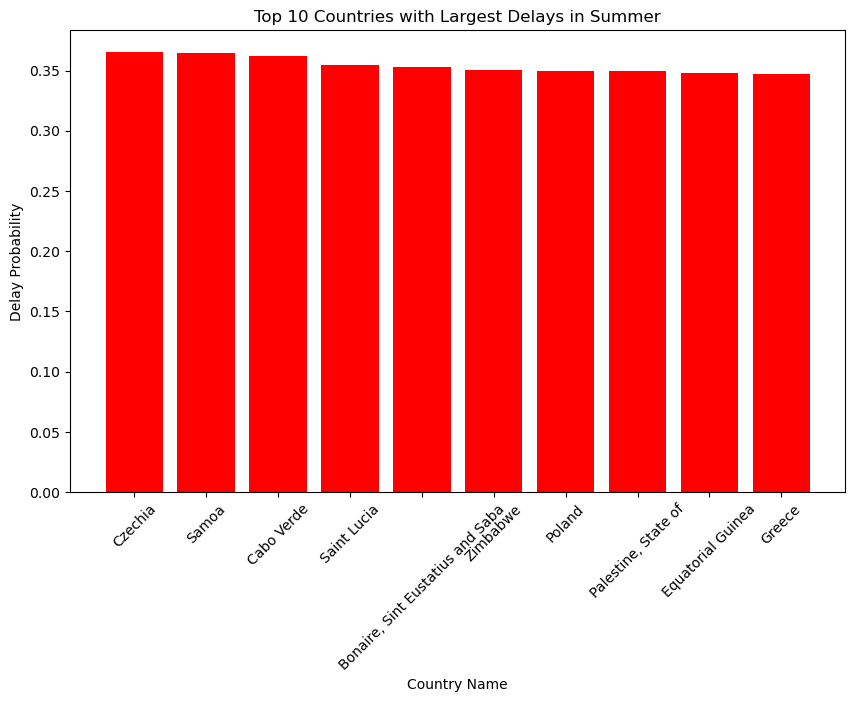

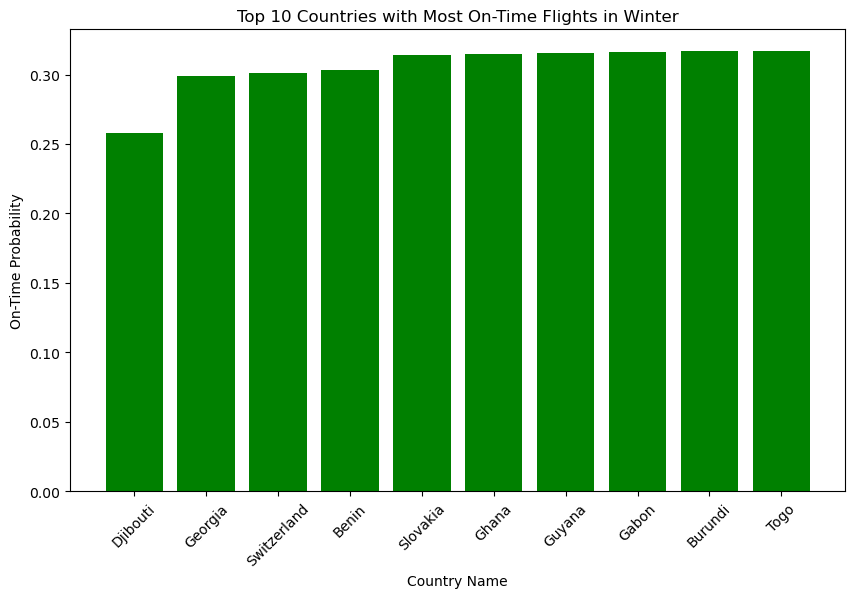

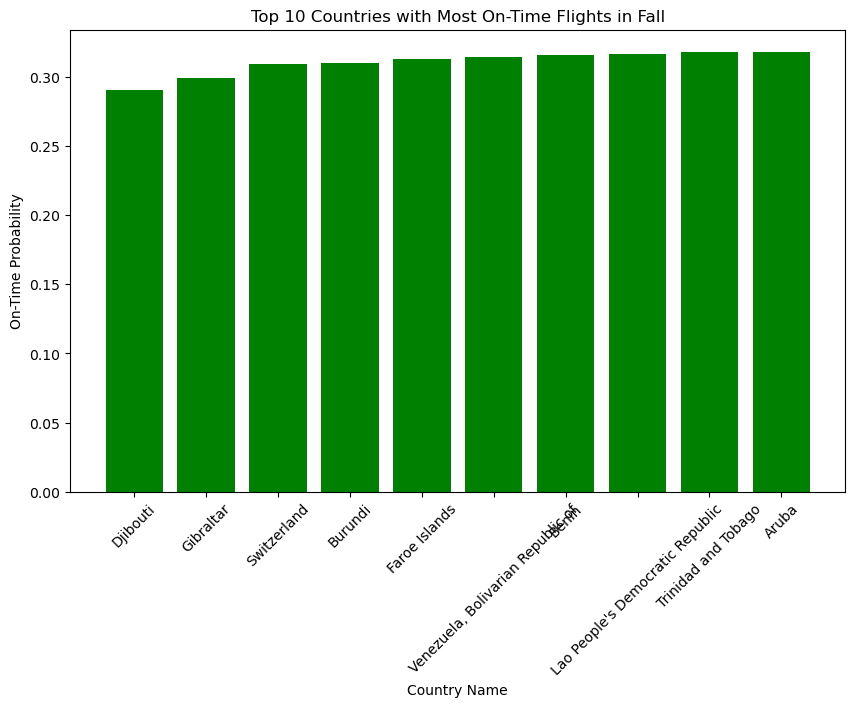

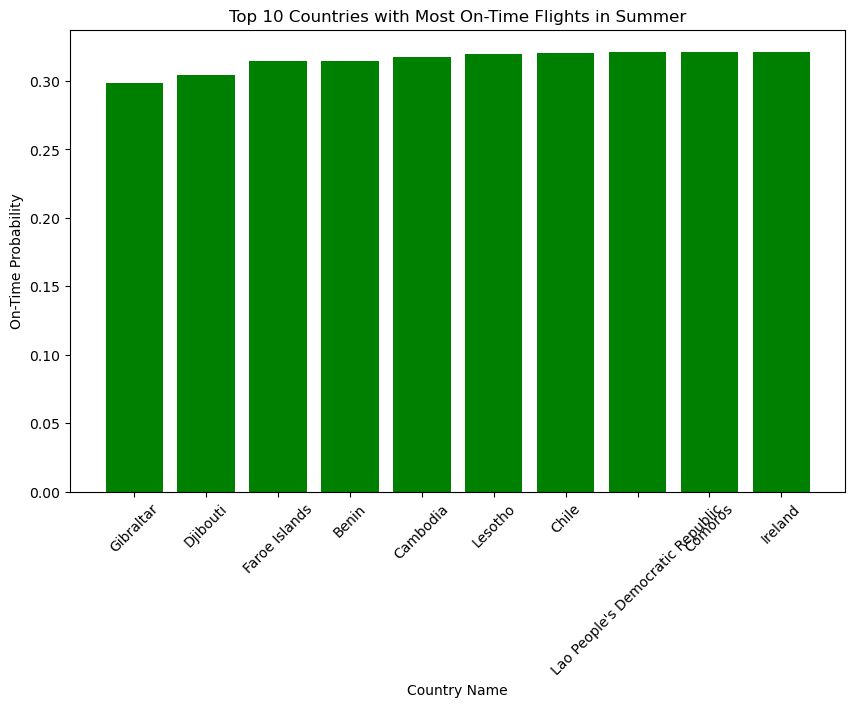

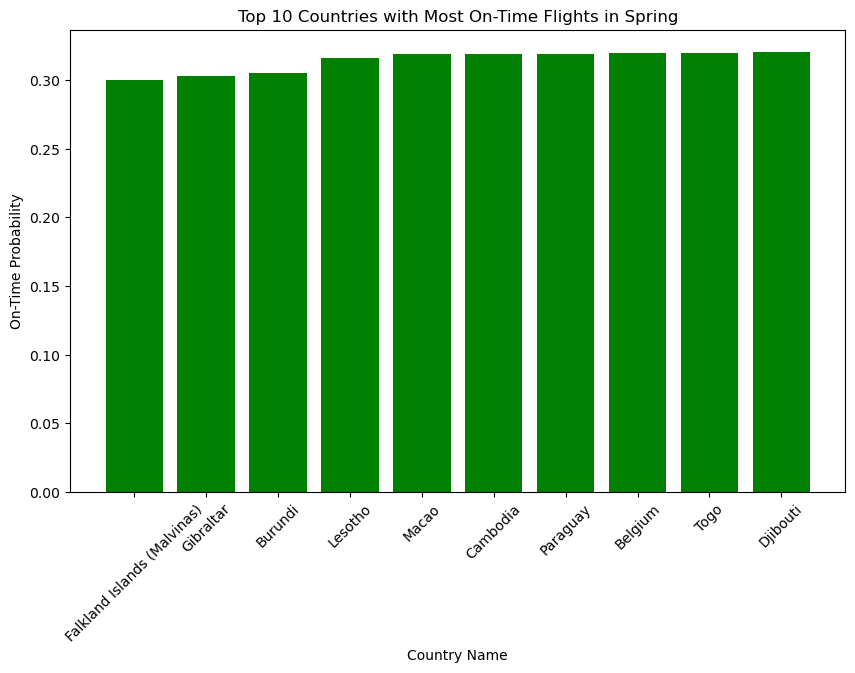

In [135]:
# Encode categorical variables
features = ['Age Group', 'Season', 'Country Name', 'Weekend', 'Airport Continent', 'Month']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Flight Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Predict probabilities for the test set
probs = model.predict_proba(X_test)
X_test = X_test.copy()  # Make a copy to avoid SettingWithCopyWarning
X_test['Country Name'] = df.loc[X_test.index, 'Country Name']
X_test['Season'] = df.loc[X_test.index, 'Season']
X_test['Flight Status'] = y_test
X_test['Delay Probability'] = probs[:, 1]  # Assuming '1' represents delays

# Aggregate probabilities by country and season
delay_probs = (
    X_test.groupby(['Country Name', 'Season'])['Delay Probability']
    .mean()
    .reset_index()
    .sort_values(by='Delay Probability', ascending=False)
)

on_time_probs = (
    X_test.groupby(['Country Name', 'Season'])['Delay Probability']
    .mean()
    .reset_index()
    .sort_values(by='Delay Probability', ascending=True)
)

# Select top 10 countries
top_10_delays = delay_probs.groupby('Season').head(10)
top_10_on_time = on_time_probs.groupby('Season').head(10)

# Visualization: Top 10 countries for delays
for season in top_10_delays['Season'].unique():
    season_data = top_10_delays[top_10_delays['Season'] == season]
    plt.figure(figsize=(10, 6))
    plt.bar(season_data['Country Name'], season_data['Delay Probability'], color='red')
    plt.title(f"Top 10 Countries with Largest Delays in {season}")
    plt.xlabel("Country Name")
    plt.ylabel("Delay Probability")
    plt.xticks(rotation=45)
    plt.show()

# Visualization: Top 10 countries for on-time flights
for season in top_10_on_time['Season'].unique():
    season_data = top_10_on_time[top_10_on_time['Season'] == season]
    plt.figure(figsize=(10, 6))
    plt.bar(season_data['Country Name'], season_data['Delay Probability'], color='green')
    plt.title(f"Top 10 Countries with Most On-Time Flights in {season}")
    plt.xlabel("Country Name")
    plt.ylabel("On-Time Probability")
    plt.xticks(rotation=45)
    plt.show()


### __Take away__:
1. Despite the model's low precision (33%), its 73% recall for cancelled flights provides a reliable signal for identifying potential cancellations. Airlines can use this to proactively notify passengers and reallocate resources, reducing operational disruptions
   
3. Leveraging the model’s high cancellation recall, airlines can implement preemptive measures, such as rebooking affected passengers or offering compensation, which can enhance customer experience and strengthen brand loyalty

## __5.) Nationalties vs Age Group vs Gender__

  Gender-Age Group
0  Female - Senior
1    Male - Senior
2    Male - Senior
3  Female - Senior
4     Male - Adult
Nationality
China            18317
Indonesia        10559
Russia            5693
Philippines       5239
Brazil            3791
Portugal          3299
Poland            3245
France            2907
Sweden            2397
United States     2105
Name: count, dtype: int64


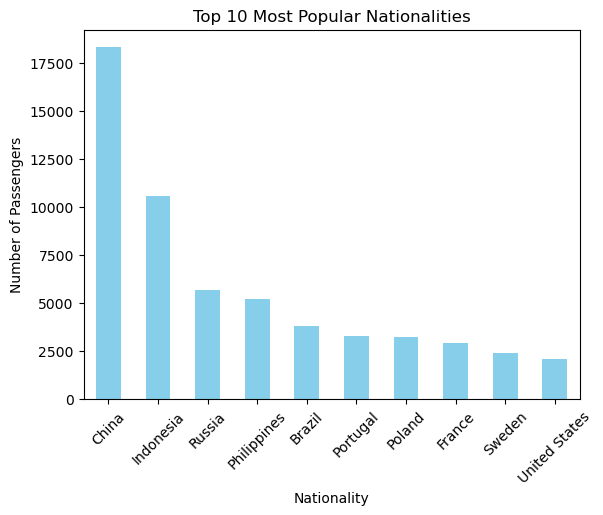

In [91]:
# Ensure Gender and Age Group are strings
df['Gender'] = df['Gender'].astype(str)
df['Age Group'] = df['Age Group'].astype(str)

# Combine Gender and Age Group into a single column
df['Gender-Age Group'] = df['Gender'] + ' - ' + df['Age Group']

print(df[['Gender-Age Group']].head())


# Count the number of passengers by nationality
nationality_counts = df['Nationality'].value_counts()

# Get the top 10 most popular nationalities
top_10_nationalities = nationality_counts.head(10)
print(top_10_nationalities)

top_10_nationalities.plot(kind='bar', color='skyblue', title='Top 10 Most Popular Nationalities')
plt.xlabel('Nationality')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.show()


     Gender-Age Group Nationality  PassengerCount
679      Male - Adult       China            4411
40     Female - Adult       China            4366
1104    Male - Senior       China            3046
464   Female - Senior       China            3005
88     Female - Adult   Indonesia            2557
729      Male - Adult   Indonesia            2484
1150    Male - Senior   Indonesia            1769
513   Female - Senior   Indonesia            1754
894      Male - Minor       China            1753
264    Female - Minor       China            1736


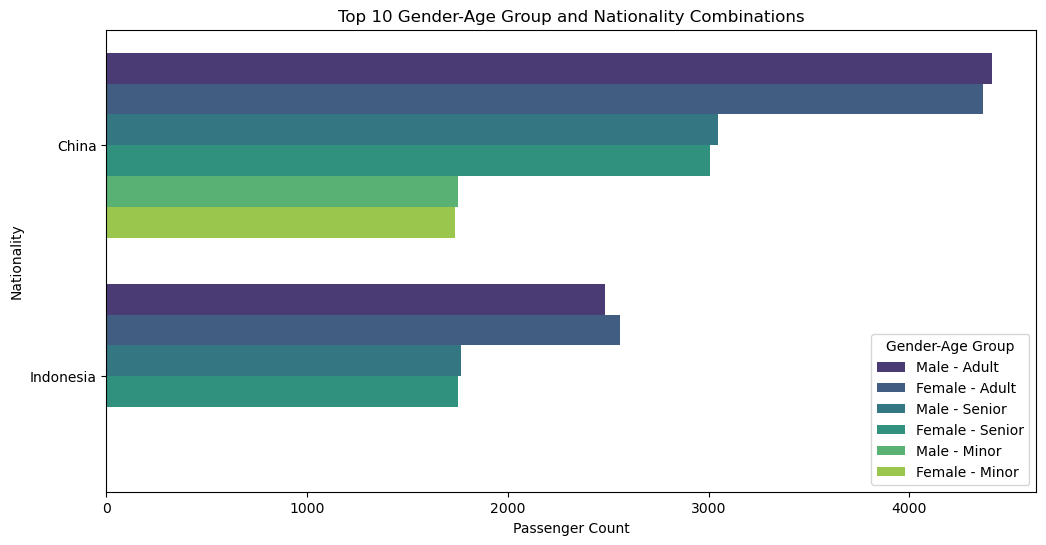

In [93]:
# Group by Gender-Age Group and Nationality and count passengers
gender_age_nationality = df.groupby(['Gender-Age Group', 'Nationality']).size().reset_index(name='PassengerCount')

# Get the top 10 combinations by passenger count
top_10_gender_age_nationality = gender_age_nationality.sort_values(by='PassengerCount', ascending=False).head(10)
print(top_10_gender_age_nationality)

# Plot a horizontal bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_gender_age_nationality,
    x='PassengerCount',
    y='Nationality',
    hue='Gender-Age Group',
    palette='viridis'
)
plt.title('Top 10 Gender-Age Group and Nationality Combinations')
plt.xlabel('Passenger Count')
plt.ylabel('Nationality')
plt.legend(title='Gender-Age Group')
plt.show()


### __Take away__:
1. China leads as the most popular nationality among passengers (18,317), followed by Indonesia (10,559). This suggests that airlines can focus on optimizing services and marketing strategies for these regions to maximize revenue and enhance customer satisfaction
   
3. The largest passenger segment is Male Adults from China (4,411), closely followed by Female Adults from China (4,366) and Male Adults from Indonesia (2,484). Tailored offerings for these demographics, such as targeted promotions or culturally relevant services, could significantly boost engagement and loyalty

## __6.) Flight Performance__

  Departure Date  Departure Month  Departure Day
0     2022-06-28                6             28
1     2022-12-26               12             26
2     2022-01-18                1             18
3     2022-09-16                9             16
4     2022-02-25                2             25


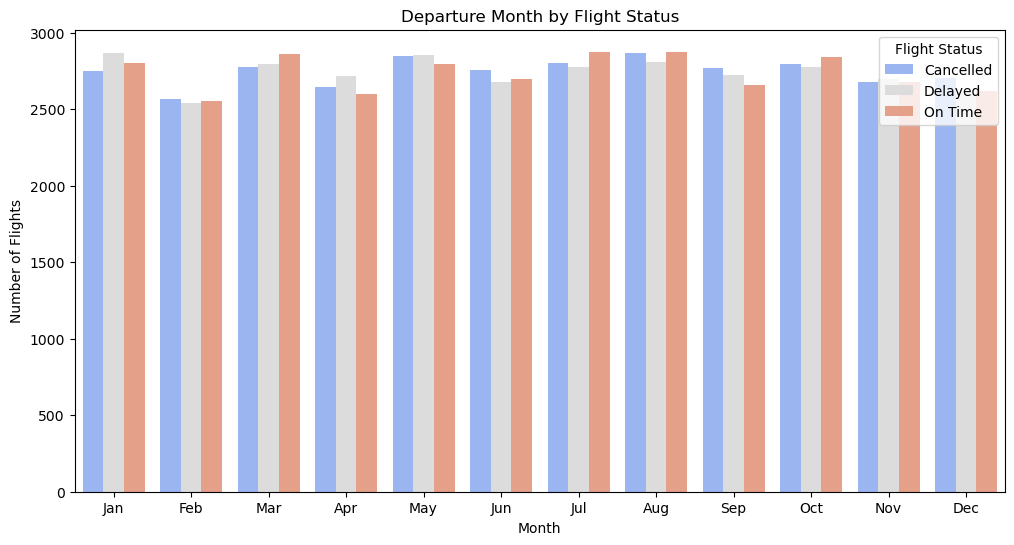

In [57]:
### Now to show PERFORMANCE compared to DELAYS 
#Number of Flights Per Month that were Cancelled, On-Time, Delayed
# Ensure Departure Date is in datetime format
df['Departure Date'] = pd.to_datetime(df['Departure Date'])

# Extract month and day
df['Departure Month'] = df['Departure Date'].dt.month
df['Departure Day'] = df['Departure Date'].dt.day

# Verify the new columns
print(df[['Departure Date', 'Departure Month', 'Departure Day']].head())


# Group by month and flight status
month_status_counts = df.groupby(['Departure Month', 'Flight Status'])['Flight Status'].count().reset_index(name='Count')

# Bar plot for departure month and flight status
plt.figure(figsize=(12, 6))
sns.barplot(data=month_status_counts, x='Departure Month', y='Count', hue='Flight Status', palette='coolwarm')
plt.title('Departure Month by Flight Status')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Flight Status')
plt.show()


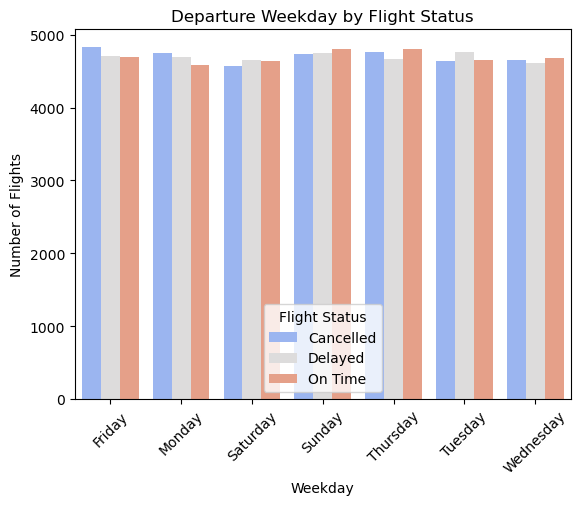

In [254]:
#Departure based on Week
df['Departure Weekday'] = df['Departure Date'].dt.day_name()
weekday_status_counts = df.groupby(['Departure Weekday', 'Flight Status'])['Flight Status'].count().reset_index(name='Count')

sns.barplot(data=weekday_status_counts, x='Departure Weekday', y='Count', hue='Flight Status', palette='coolwarm')
plt.title('Departure Weekday by Flight Status')
plt.xlabel('Weekday')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Flight Status')
plt.show()

In [83]:
# Group by Departure Date to calculate daily flight counts
daily_flights = df.groupby('Departure Date').size().reset_index(name='DailyFlights')

# Convert Departure Date to datetime if it's not already
daily_flights['Departure Date'] = pd.to_datetime(daily_flights['Departure Date'])

# Calculate the cumulative sum of flights
daily_flights['CumulativeFlights'] = daily_flights['DailyFlights'].cumsum()

# Verify the data
print(daily_flights.head())

  Departure Date  DailyFlights  CumulativeFlights
0     2022-01-01           267                267
1     2022-01-02           249                516
2     2022-01-03           252                768
3     2022-01-04           267               1035
4     2022-01-05           271               1306


### __Take away__:
1. Flight numbers remain relatively stable across all months and weekday/weekends, with no significant spikes or drops in volume. This suggests a consistent demand for air travel throughout the year, making monthly variations less critical for operational planning

## __7.) Operation Metrics__

In [65]:
# Ensure Flight Status column has consistent casing and no extra spaces
df['Flight Status'] = df['Flight Status'].str.strip().str.title()

# Calculate total flights
total_flights = len(df)

# Calculate the number of on-time, canceled, and delayed flights
on_time_flights = len(df[df['Flight Status'] == 'On Time'])
canceled_flights = len(df[df['Flight Status'] == 'Cancelled'])
delayed_flights = len(df[df['Flight Status'] == 'Delayed'])

# Calculate percentages
if total_flights > 0:
    on_time_percentage = (on_time_flights / total_flights) * 100
    canceled_percentage = (canceled_flights / total_flights) * 100
    delayed_percentage = (delayed_flights / total_flights) * 100

    print(f"On-Time Performance: {on_time_percentage:.2f}%")
    print(f"Canceled Flights: {canceled_percentage:.2f}%")
    print(f"Delayed Flights: {delayed_percentage:.2f}%")
else:
    print("No flights available to calculate percentages.")


On-Time Performance: 33.31%
Canceled Flights: 33.40%
Delayed Flights: 33.29%


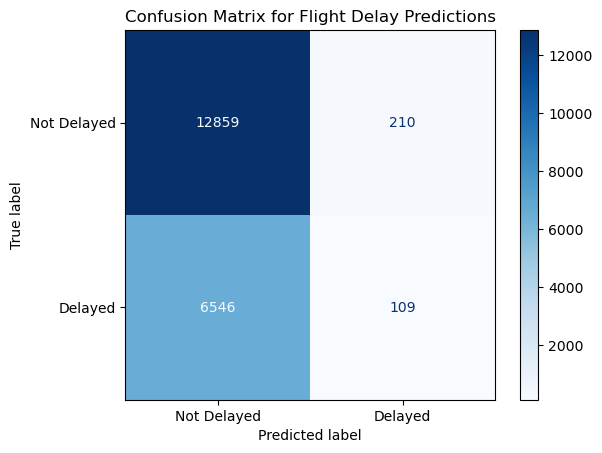

In [149]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Delayed', 'Delayed'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Flight Delay Predictions")
plt.show()


### __Take away__:
1. The distribution of flight statuses is nearly even among On-Time, Cancelled, and Delayed (each around 33%). This highlights a potential imbalance issue in real-world data where the causes of delays might overlap with those of cancellations or on-time flights
2. The confusion matrix reveals a high rate of false negatives for Delayed flights (6,546 misclassified as Not Delayed). This indicates the need for better feature engineering (e.g., weather data, airport congestion) or balancing the dataset to ensure the model gives equal focus to delays

# __Conclusion__:

Despite limitations in the dataset and weak predictive factors, the analysis revealed key insights to maximize flight demand. **China and Indonesia** emerged as dominant passenger nationalities, with **Male Adults** being the largest demographic. Flights remained stable across months and weekdays, highlighting consistent demand, while delays peaked in high-traffic regions like **North America**. 
Focusing on passenger-centric strategies, such as targeted services for key demographics and operational improvements in delay-prone regions, can enhance customer satisfaction and boost demand. Future analyses with enriched data (e.g., weather and traffic) could refine predictions and further optimize airline operations